Need to clone lsst/throughputs and setenv THROUGHPUTS_DIR to point to that directory first.

In [1]:
from collections import OrderedDict as odict

import sncosmo
import analyzeSN as ans

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Comparison of model and simulated data
We already know how to extract the data from the simulations. The data is the model light curve + noise. The model used here is SALT2, which has a few parameters ['x0', 'x1', 'c', 'z', 't0']. We must estimate the values of these parameters from the data

In [2]:
simdata = ans.SNANASims.fromSNANAfileroot('LSST_Ia', location='ENIGMA_LSSTMAIN/', coerce_inds2int=False)
print simdata.headData.shape

(1622, 78)


Find SNe with large numbers of observations (for demonstration)

In [3]:
nobs = [simdata.get_SNANA_photometry(snid=snid).lightCurve.shape[0] for snid in simdata.headData.index.values]

In [4]:
print np.array(nobs).max()
snid = simdata.headData.index.values[np.argmax(np.array(nobs))]
print snid

71
3942


In [5]:
#hd = simdata.headData.query('REDSHIFT_FINAL > 0.2 and REDSHIFT_FINAL < 0.25').head(5).copy()
hd = simdata.headData.query('NOBS > 50').head(5).copy()
#hd = simdata.headData.query('REDSHIFT_FINAL < 0.1').head(5).copy()
#snid = hd.index.values[2]
print snid
hd

3942


IAUC  FAKE        RA      DECL  PIXSIZE  NXPIX  NYPIX  SNTYPE  \
SNID                                                                       
3942   NULL         2  0.000000 -0.794553      0.2     -9     -9       1   
14174  NULL         2  2.646689 -0.355408      0.2     -9     -9       1   

       NOBS  PTROBS_MIN      ...        SIM_EXPOSURE_r  SIM_EXPOSURE_i  \
SNID                         ...                                         
3942     71        5757      ...                   1.0             1.0   
14174    51       20809      ...                   1.0             1.0   

       SIM_EXPOSURE_z  SIM_EXPOSURE_Y  SIM_GALFRAC_u  SIM_GALFRAC_g  \
SNID                                                                  
3942              1.0             1.0           -9.0           -9.0   
14174             1.0             1.0           -9.0           -9.0   

       SIM_GALFRAC_r  SIM_GALFRAC_i  SIM_GALFRAC_z  SIM_GALFRAC_Y  
SNID                                                               
3942            -9.0           -9.0           -9.0           -9.0  
14174           -9.0           -9.0           -9.0           -9.0  

[2 rows x 78 columns]

In [6]:
lcobj = simdata.get_SNANA_photometry(snid=snid)
print lcobj.lightCurve.shape
#lcobj.lightCurve

(71, 22)


In [7]:
print simdata.headData.ix[snid]
hd['SIM_SALT2x0'] = hd.SIM_SALT2x0 * 10.0**(-0.4 * 0.27)
hd['params'] = hd[['SIM_PEAKMJD', 'SIM_SALT2x0', 'SIM_SALT2x1', 'SIM_SALT2c', 'REDSHIFT_FINAL', ]].rename(columns=dict(SIM_PEAKMJD='t0', 
                                                                                    SIM_SALT2x0='x0',
                                                                                    SIM_SALT2x1='x1',
                                                                                    SIM_SALT2c='c',
                                                                                    SIM_MWEBV='ebv',                                   
                                                                                    REDSHIFT_FINAL='z')).apply(odict, axis=1)

IAUC                      NULL    
FAKE                             2
RA                               0
DECL                     -0.794553
PIXSIZE                        0.2
NXPIX                           -9
NYPIX                           -9
SNTYPE                           1
NOBS                            71
PTROBS_MIN                    5757
PTROBS_MAX                    5827
MWEBV                         0.01
MWEBV_ERR                   0.0016
REDSHIFT_HELIO            0.774001
REDSHIFT_HELIO_ERR          0.0005
REDSHIFT_FINAL            0.771876
REDSHIFT_FINAL_ERR          0.0005
HOSTGAL_OBJID                12333
HOSTGAL_PHOTOZ            0.764214
HOSTGAL_PHOTOZ_ERR           0.014
HOSTGAL_SPECZ                    0
HOSTGAL_SPECZ_ERR                0
HOSTGAL_SNSEP                 -999
HOSTGAL_LOGMASS                 -9
HOSTGAL_LOGMASS_ERR             -9
HOSTGAL_MAG_u                  999
HOSTGAL_MAG_g                  999
HOSTGAL_MAG_r                  999
HOSTGAL_MAG_i       

In [8]:
hd['params'].ix[snid]

OrderedDict([('t0', 52534.863),
             ('x0', 3.3000356e-06),
             ('x1', 0.7941221),
             ('c', 0.042838477),
             ('z', 0.77187568)])

In [9]:
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2-extended', effects=[dust, dust], 
                     effect_names=['host', 'mw'], effect_frames=['rest', 'obs'])
model.set(**hd.ix[snid].params)

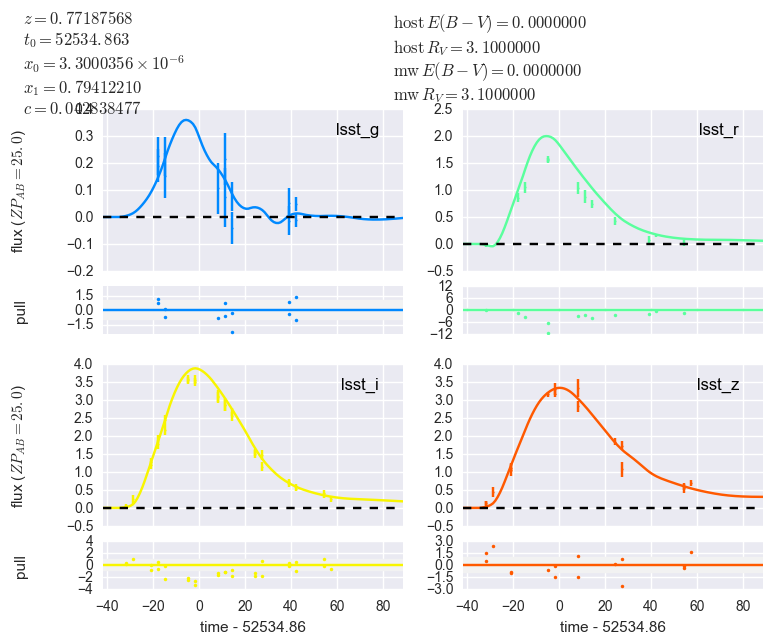

In [10]:
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=model)

### Inferring the model parameters from the data
First we will use a max likelihood method for estimating the model parameters

In [11]:
fitres = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=True)

In [12]:
print fitres[0].parameters
fitresChar = ans.ResChar.fromSNCosmoRes(fitres)
fitresChar.parameters

[  7.71875679e-01   5.25347521e+04   3.04715181e-06   1.07785611e+00
   1.34853398e-01   0.00000000e+00   3.10000000e+00   0.00000000e+00
   3.10000000e+00]


z              0.771876
t0         52534.752133
x0             0.000003
x1             1.077856
c              0.134853
hostebv        0.000000
hostr_v        3.100000
mwebv          0.000000
mwr_v          3.100000
dtype: float64

In [13]:
fitresChar.vparams

t0    52534.752133
x0        0.000003
x1        1.077856
c         0.134853
dtype: float64

In [14]:
fitresChar.salt_covariance_linear()

mB        x1         c
mB  0.000676  0.001871  0.000261
x1  0.001871  0.030523  0.000616
c   0.000261  0.000616  0.001676

Errors on model parameters. Including mu.

In [15]:
fitresChar.mu_variance_linear()**0.5

0.12549059972782525

In [16]:
print fitresChar.sncosmoModel.parameters
print fitresChar.sncosmoModel.param_names
#??fitresChar.salt_covariance_linear

[  7.71875679e-01   5.25347521e+04   3.04715181e-06   1.07785611e+00
   1.34853398e-01   0.00000000e+00   3.10000000e+00   0.00000000e+00
   3.10000000e+00]
['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']


### Compute mu from model parameters. 

Notes from Rahul:
    
Yes the issue is with `mB` … the true SALT definition is it is the apparent mag in the BessellB rest frame band.

In the SALT model this turns out to be -2.5 log10(x0) + constant to a very good approximation.

Those numbers come from fitting a sample of SN  (real data) eg JLA.

In [5]:
def computeMu(fitresChar, alpha=0.14, beta=-3.11):
    # mu = alpha * x1 + beta * c + mB + const and set alpha = 0.14, beta = -3.11
    # mB = -2.5 log10(x0) ? (approximately)
    mB = -2.5 * np.log10(fitresChar.parameters['x0'])
    mu = alpha * fitresChar.parameters['x1'] + beta * fitresChar.parameters['c'] + mB #+ const
    return mu

In [18]:
computeMu(fitresChar)

13.52177056055231

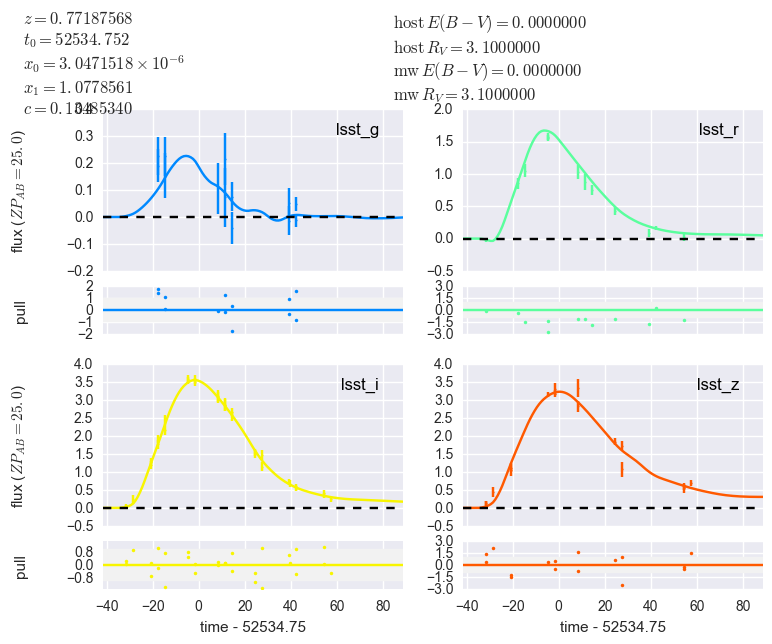

In [19]:
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=fitresChar.sncosmoModel)

### What if we did not know z?

In [20]:
fitres_z = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c', 'z'], guess_z=True, 
                          bounds=dict(z=(0.65, 0.85)),
                          modelcov=True)

In [21]:
fitresChar_z = ans.ResChar.fromSNCosmoRes(fitres_z)
fitresChar_z.parameters

z              0.788165
t0         52534.978648
x0             0.000003
x1             1.086349
c              0.104184
hostebv        0.000000
hostr_v        3.100000
mwebv          0.000000
mwr_v          3.100000
dtype: float64

In [22]:
fitresChar_z.mu_variance_linear()**0.5

0.15256956415820788

13.6186340447


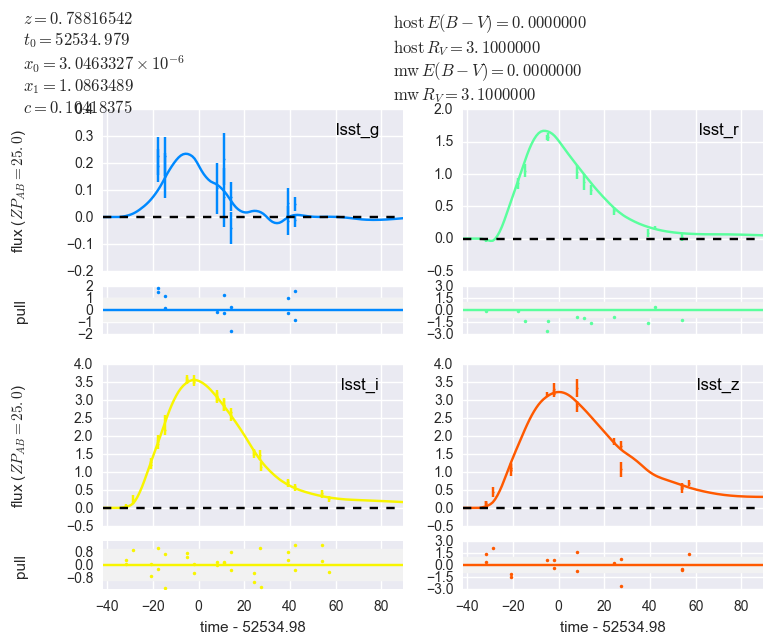

In [23]:
print computeMu(fitresChar_z)
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=fitresChar_z.sncosmoModel)

### Now we repeat this in a different method
The maximum likelihood method above is not good if the likelihood are too far from the Gaussian. A method to sample posteriors is better. Such a method can be based on a MCMC run. We do that here by the following code

These are samples of these parameters :

### Fit all of the SNe.

In [7]:
## Capture verbose output so it's not printed.
## See: http://stackoverflow.com/questions/16571150/how-to-capture-stdout-output-from-a-python-function-call
## Note this is not thread-safe so I just edited the code for ans.mu_variance_linear()
from cStringIO import StringIO
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        sys.stdout = self._stdout

def computeMu(fitresChar, alpha=0.14, beta=-3.11):
    # mu = alpha * x1 + beta * c + mB + const and set alpha = 0.14, beta = -3.11
    # mB = -2.5 log10(x0) ? (approximately)
    mB = -2.5 * np.log10(fitresChar.parameters['x0'])
    mu = alpha * fitresChar.parameters['x1'] + beta * fitresChar.parameters['c'] + mB #+ const
    return mu

def fitSN(snid, verbose=False, plot=False):
    outParams = None
    try:
        lcobj = simdata.get_SNANA_photometry(snid=snid)
        if verbose:
            print snid, lcobj.lightCurve.shape[0]
        hd = simdata.headData.copy() #simdata.headData.query('SNID == %s' % snid).head(5).copy()
        hd['SIM_SALT2x0'] = hd.SIM_SALT2x0 * 10.0**(-0.4 * 0.27)
        hd['params'] = hd[['SIM_PEAKMJD', 'SIM_SALT2x0', 'SIM_SALT2x1', 'SIM_SALT2c', 'REDSHIFT_FINAL', ]].rename(columns=dict(SIM_PEAKMJD='t0', 
                                                                            SIM_SALT2x0='x0',
                                                                            SIM_SALT2x1='x1',
                                                                            SIM_SALT2c='c',
                                                                            SIM_MWEBV='ebv',                                   
                                                                            REDSHIFT_FINAL='z')).apply(odict, axis=1)
        dust = sncosmo.CCM89Dust()
        model = sncosmo.Model(source='salt2-extended', effects=[dust, dust], 
                         effect_names=['host', 'mw'], effect_frames=['rest', 'obs'])
        model.set(**hd.ix[snid].params)
        if plot:
            sncosmo.plot_lc(lcobj.snCosmoLC(), model=model)
        fitres = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=True)
        fitresChar = ans.ResChar.fromSNCosmoRes(fitres)
        outParams = fitresChar.parameters.copy()
        outParams['mu'] = computeMu(fitresChar)
        #with Capturing() as output:
        outParams['mu_var'] = fitresChar.mu_variance_linear()**0.5
        outParams['inputParams'] = hd['params'].ix[snid]
    except Exception as e:
        if verbose:
            print snid, e
        pass
        #raise e
    return outParams

In [8]:
print fitSN(snid)

z                                                       0.771876
t0                                                       52534.8
x0                                                   3.04716e-06
x1                                                       1.07809
c                                                        0.13487
hostebv                                                        0
hostr_v                                                      3.1
mwebv                                                          0
mwr_v                                                        3.1
mu                                                       13.5217
mu_var                                                  0.125494
inputParams    {u't0': 52534.9, u'x0': 3.30004e-06, u'x1': 0....
dtype: object


In [12]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import gzip, cPickle
#snFits = Parallel(n_jobs=num_cores, verbose=2)(delayed(fitSN)(id, verbose=True) \
#                                               for id in simdata.headData.index.values)
#snFits = {id: fitSN(id, verbose=True) for id in simdata.headData.index.values}
snFits = {}
for id in simdata.headData.index.values:
    snFits[id] = fitSN(id, verbose=True)
    cPickle.dump(snFits, gzip.GzipFile('snFits.p.gz', 'wb'))

3
3 6
4 28
47 22
50 17
74 27
84 30
89 23
95 16
97 6
106 13
117 27
126 36
129 15
140 12
150 17


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.011432
         t0 = +50187.933716
         x0 = +0.024500
         x1 = -194.148162
          c = -64.356096
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


150 fcn returns Nan
fcn is called with following arguments:
          z = +1.011432
         t0 = +50187.933716
         x0 = +0.024500
         x1 = -194.148162
          c = -64.356096
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

152 25
194 28
206 31


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.012637
         t0 = +51889.456047
         x0 = +13597379085.573263
         x1 = +123.899479
          c = +1901.900176
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


206 fcn returns Nan
fcn is called with following arguments:
          z = +1.012637
         t0 = +51889.456047
         x0 = +13597379085.573263
         x1 = +123.899479
          c = +1901.900176
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

290 32


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.069105
         t0 = +50911.872720
         x0 = -498826.361018
         x1 = +139024703731.953491
          c = -83601925354.635773
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


290 fcn returns Nan
fcn is called with following arguments:
          z = +1.069105
         t0 = +50911.872720
         x0 = -498826.361018
         x1 = +139024703731.953491
          c = -83601925354.635773
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

316 7
320 28
333 13
354 30
369 26
380 24
407 11
441 25
499 21
528 29
571 23
575 33
578 31
596 36
629 21
632 19
714 25
736 11
747 37
752 37
755 22
784 35
795 18
821 27
851 31
862 26
873 22
873 No data points with S/N > 5.0. Initial guessing failed.
926 28
955 15
963 18
973 28
974 24
980 38
981 34
986 14
1014 31
1028 28
1042 21
1050 35
1053 21
1061 25
1089 28
1094 18
1103 18
1187 12
1188 23
1196 31
1216 21
1217 40
1234 39
1269 29
1326 27
1339 27
1364 36
1422 11
1439 26
1445 5
1447 21
1457 34


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.843532
         t0 = +51408.944832
         x0 = +446137661254.639160
         x1 = +1059.866631
          c = +69953.807005
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


1457 fcn returns Nan
fcn is called with following arguments:
          z = +0.843532
         t0 = +51408.944832
         x0 = +446137661254.639160
         x1 = +1059.866631
          c = +69953.807005
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

1461 20
1479 34
1500 27
1513 23
1518 39
1551 24
1583 26
1678 33
1685 34
1686 41
1688 15
1701 32
1708 19
1708 No data points with S/N > 5.0. Initial guessing failed.
1709 15
1723 32
1734 23
1736 12
1764 12
1769 40
1770 29
1779 17
1784 47


/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


1807 11
1854 19
1895 30
1911 16
1921 29
1934 8
1972 11
1975 9
1988 6
1997 15
2026 23
2038 26
2053 35
2069 34
2112 23
2116 38
2122 7
2126 14
2157 27
2164 29
2168 36
2180 23
2186 12
2216 19
2233 27
2236 8
2284 29
2289 16
2290 32
2295 6
2342 34
2343 17
2357 6
2408 45
2409 25
2450 11
2453 26
2455 24
2507 20
2544 23
2559 23
2560 12
2578 37
2592 29
2601 31
2603 24
2611 32
2619 25
2671 22


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.883232
         t0 = +51749.526575
         x0 = +41242.672114
         x1 = -1360.332553
          c = -45.659952
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


2671 fcn returns Nan
fcn is called with following arguments:
          z = +0.883232
         t0 = +51749.526575
         x0 = +41242.672114
         x1 = -1360.332553
          c = -45.659952
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

2694 22
2712 27
2719 16
2735 28
2769 8
2770 40
2773 32
2784 35
2799 25
2807 32


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.156946
         t0 = +52789.754435
         x0 = -195956927.348058
         x1 = +1.744826
          c = -86.558709
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


2807 fcn returns Nan
fcn is called with following arguments:
          z = +1.156946
         t0 = +52789.754435
         x0 = -195956927.348058
         x1 = +1.744826
          c = -86.558709
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

2810 36
2811 14
2828 33
2841 21
2853 33
2858 8
2862 27
2863 23
2925 25
2945 36
2948 30
2950 8
2973 28
2995 44
2999 29
3028 28
3028 No data points with S/N > 5.0. Initial guessing failed.
3035 28
3060 25
3067 32
3093 30
3114 22
3146 5
3155 30
3163 30
3192 6
3192 fcn returns Nan
fcn is called with following arguments:
          z = +0.831650
         t0 = +51464.601385
         x0 = -99902361.354156
         x1 = +18.725175
          c = -162.438232
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

3202 40
3206 9
3225 16
3227 32
3241 24
3250 5
3257 33
3270 37
3286 27
3294 23
3299 25


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.155899
         t0 = +49831.142663
         x0 = +573791.801541
         x1 = -19868384866791.574219
          c = -547412133408.183777
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


3299 fcn returns Nan
fcn is called with following arguments:
          z = +1.155899
         t0 = +49831.142663
         x0 = +573791.801541
         x1 = -19868384866791.574219
          c = -547412133408.183777
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

3361 8
3368 43
3388 21
3396 28
3433 16
3466 24


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.671515
         t0 = +50252.307232
         x0 = +387762.457626
         x1 = -0.525655
          c = -46.060795
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


3466 fcn returns Nan
fcn is called with following arguments:
          z = +0.671515
         t0 = +50252.307232
         x0 = +387762.457626
         x1 = -0.525655
          c = -46.060795
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

3492 6
3534 16
3589 25
3597 33
3638 24
3642 40
3643 14
3663 27
3680 9
3690 31
3742 12
3762 39
3766 36
3789 20
3817 22
3820 31
3834 30
3845 10
3858 8
3870 19
3879 36
3886 21


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.950638
         t0 = +50068.856294
         x0 = +5823923.892653
         x1 = -11.944157
          c = -188.191836
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


3886 fcn returns Nan
fcn is called with following arguments:
          z = +0.950638
         t0 = +50068.856294
         x0 = +5823923.892653
         x1 = -11.944157
          c = -188.191836
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

3905 5
3906 28
3907 19
3928 27
3935 38
3936 31
3942 71
3959 20
3968 17
3968 need more than 0 values to unpack
3991 18
4007 26
4062 34
4065 28
4092 28
4105 39
4113 13
4141 11
4171 13
4189 16
4192 32


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.769434
         t0 = +52605.866392
         x0 = +42924.162773
         x1 = -42.384231
          c = -239.812523
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


4192 fcn returns Nan
fcn is called with following arguments:
          z = +0.769434
         t0 = +52605.866392
         x0 = +42924.162773
         x1 = -42.384231
          c = -239.812523
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

4206 35
4208 29
4217 33
4307 7
4315 34
4328 32
4333 28
4386 25
4405 31
4463 32
4464 19
4476 8
4484 13
4485 22
4515 24
4527 12
4558 33
4564 19
4579 29


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.888181
         t0 = +51385.560980
         x0 = +0.000001
         x1 = -3.547269
          c = +1338.201903
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


4579 fcn returns Nan
fcn is called with following arguments:
          z = +0.888181
         t0 = +51385.560980
         x0 = +0.000001
         x1 = -3.547269
          c = +1338.201903
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

4616 29
4677 25
4686 30
4687 11
4697 9
4724 38
4753 22
4760 38
4790 25
4792 14
4816 21
4822 12
4835 39
4838 16
4849 30
4872 18
4876 22
4883 40
4918 31
4923 41
4927 19
4932 24


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.186143
         t0 = +52523.519098
         x0 = -320951.752611
         x1 = +18.281522
          c = -33.433249
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


4932 fcn returns Nan
fcn is called with following arguments:
          z = +1.186143
         t0 = +52523.519098
         x0 = -320951.752611
         x1 = +18.281522
          c = -33.433249
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

4934 38
4988 17
5001 34
5046 13
5063 10
5073 26


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.547857
         t0 = +51189.498981
         x0 = +22528489230.919369
         x1 = -472.669095
          c = +45781383.546574
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


5073 fcn returns Nan
fcn is called with following arguments:
          z = +0.547857
         t0 = +51189.498981
         x0 = +22528489230.919369
         x1 = -472.669095
          c = +45781383.546574
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

5133 6
5146 27
5149 8
5181 20
5186 24
5192 25
5196 40
5203 39
5208 15


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/models.py:1447: RuntimeWarning: overflow encountered in multiply
  cov = f * rcov * f[:, np.newaxis]
/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.868773
         t0 = +50668.744185
         x0 = +995867.688733
         x1 = -0.609313
          c = -24.744489
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


5208 fcn returns Nan
fcn is called with following arguments:
          z = +0.868773
         t0 = +50668.744185
         x0 = +995867.688733
         x1 = -0.609313
          c = -24.744489
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

5241 29
5262 31
5265 19
5319 40
5359 36
5372 26
5378 29
5381 13
5392 34
5399 16
5482 12
5502 11
5509 31
5549 10
5553 17


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.375222
         t0 = +51312.630275
         x0 = +295754.924716
         x1 = +12.394864
          c = -41.961518
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


5553 fcn returns Nan
fcn is called with following arguments:
          z = +0.375222
         t0 = +51312.630275
         x0 = +295754.924716
         x1 = +12.394864
          c = -41.961518
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

5563 18
5586 12
5591 10
5632 20
5673 41
5688 20
5712 43
5756 22
5763 6
5777 24
5787 19
5788 16
5789 36
5809 22
5834 20
5837 12
5919 37
5924 37
5930 16
5956 29
5974 30
5986 9
5989 34
6008 33
6025 29
6047 28
6049 33
6063 36
6083 36
6095 34
6124 33
6128 19
6147 27
6175 6
6180 24
6182 9
6196 24
6215 17
6270 22
6271 33
6317 38
6320 30
6321 39
6329 15
6365 25
6371 41
6418 20
6421 14
6432 16
6455 30
6494 25
6517 15
6575 25
6581 26
6610 11
6636 28
6642 27
6645 24
6666 27
6672 36
6673 33
6676 10
6677 14
6707 24
6739 29
6765 36
6783 24
6784 34
6813 15
6849 24
6855 38
6875 40
6880 37
6892 35
6899 44
6903 38
6927 22
6936 38
6951 29
6963 38
6978 25
6983 32
6992 15
7003 33
7006 10
7019 33
7036 36
7054 32
7061 41


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.169662
         t0 = +51473.256236
         x0 = -3115804.504957
         x1 = -0.899703
          c = -91.605912
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


7061 fcn returns Nan
fcn is called with following arguments:
          z = +1.169662
         t0 = +51473.256236
         x0 = -3115804.504957
         x1 = -0.899703
          c = -91.605912
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

7065 23
7113 26
7127 26
7139 31
7157 36
7181 8
7185 39
7190 34
7192 15
7204 26
7218 21
7222 26
7232 46
7280 21
7309 23
7312 29
7319 28
7337 23
7360 9
7368 24
7381 38
7399 32
7408 34
7430 38
7439 24
7442 27
7470 27


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.751122
         t0 = +52486.200282
         x0 = +3133722.408632
         x1 = +42200345999951.351562
          c = +2515086873960289.500000
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


7470 fcn returns Nan
fcn is called with following arguments:
          z = +0.751122
         t0 = +52486.200282
         x0 = +3133722.408632
         x1 = +42200345999951.351562
          c = +2515086873960289.500000
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

7475 7


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.294922
         t0 = +49404.031284
         x0 = +3338321.952775
         x1 = -64.186881
          c = +488.885054
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


7475 fcn returns Nan
fcn is called with following arguments:
          z = +0.294922
         t0 = +49404.031284
         x0 = +3338321.952775
         x1 = -64.186881
          c = +488.885054
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

7487 24
7488 32
7491 10
7502 33
7525 9
7549 36
7559 29
7602 19
7616 38
7641 31
7677 37
7732 42
7738 8
7740 28
7740 No data points with S/N > 5.0. Initial guessing failed.
7742 31
7746 16
7747 46
7775 33
7851 43
7865 40
7885 25


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.108565
         t0 = +52497.131577
         x0 = +71245560.744169
         x1 = +1.121484
          c = -35.147792
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


7885 fcn returns Nan
fcn is called with following arguments:
          z = +1.108565
         t0 = +52497.131577
         x0 = +71245560.744169
         x1 = +1.121484
          c = -35.147792
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

7887 24
7899 29
7952 32
7958 31
7982 13
7983 5
7989 13
7991 24
7995 43
8023 30
8059 40
8070 9
8094 34
8100 32
8108 13
8120 40
8135 10
8149 22
8152 16
8153 16
8215 32
8258 6
8261 41
8268 15
8273 36
8315 24
8335 12
8347 33
8354 11
8370 37


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.983633
         t0 = +51116.458573
         x0 = -62344.017348
         x1 = -19987151775.207748
          c = -10331767246.307692
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


8370 fcn returns Nan
fcn is called with following arguments:
          z = +0.983633
         t0 = +51116.458573
         x0 = -62344.017348
         x1 = -19987151775.207748
          c = -10331767246.307692
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

8398 7
8407 12
8415 22
8422 11
8426 16
8444 8
8452 33
8472 17
8485 26
8544 26
8554 16
8607 30
8625 33
8638 32
8649 24
8657 11
8665 6
8673 13
8675 31
8685 15
8689 27
8694 6
8739 11
8750 42
8765 8
8772 17
8797 29
8804 8
8815 7
8836 42
8872 14
8884 36
8888 9
8895 12
8897 18
8917 15
8947 19
8957 28
8959 26
8999 37
9035 29
9062 8
9085 40
9096 14
9112 22
9122 38
9128 29
9150 25
9154 25
9159 31
9176 13
9180 20
9205 15
9237 17


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.851546
         t0 = +49313.122006
         x0 = -12397602.418364
         x1 = -26.013000
          c = -53.354247
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


9237 fcn returns Nan
fcn is called with following arguments:
          z = +0.851546
         t0 = +49313.122006
         x0 = -12397602.418364
         x1 = -26.013000
          c = -53.354247
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

9246 21
9248 5
9250 33
9259 11
9262 24
9286 9
9290 36
9360 37
9398 12
9406 30
9411 27


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.132177
         t0 = +49844.103296
         x0 = +318028465.022209
         x1 = +29.305769
          c = -737.502330
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


9411 fcn returns Nan
fcn is called with following arguments:
          z = +1.132177
         t0 = +49844.103296
         x0 = +318028465.022209
         x1 = +29.305769
          c = -737.502330
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

9422 41
9469 22
9497 38
9544 35
9548 34
9568 15
9570 10
9596 22
9608 35
9647 16
9672 17
9681 35
9702 33
9706 20
9716 22
9736 19
9736 No data points with S/N > 5.0. Initial guessing failed.
9784 16
9831 20
9845 20
9875 27
9893 5
9906 6
9919 35
9940 23
9956 17
9966 26
9996 39
9997 11
9998 26
10005 36
10018 20


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.588004
         t0 = +50498.100924
         x0 = +1231126488.125259
         x1 = +378.029888
          c = +2607.345573
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


10018 fcn returns Nan
fcn is called with following arguments:
          z = +0.588004
         t0 = +50498.100924
         x0 = +1231126488.125259
         x1 = +378.029888
          c = +2607.345573
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

10024 16
10034 30
10059 42
10087 25
10092 11
10135 19
10136 10
10186 11
10191 30
10194 25
10211 20
10216 24
10220 38
10270 34
10275 19
10355 31
10375 35
10389 20
10395 33


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.460120
         t0 = +50514.791774
         x0 = -55470653996.556885
         x1 = +769.164227
          c = -3706.338859
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


10395 fcn returns Nan
fcn is called with following arguments:
          z = +0.460120
         t0 = +50514.791774
         x0 = -55470653996.556885
         x1 = +769.164227
          c = -3706.338859
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

10399 33
10413 23
10429 27
10483 34
10547 9
10565 38


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.733383
         t0 = +52626.722658
         x0 = -1716924.154513
         x1 = -101.879940
          c = -36.782708
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


10565 fcn returns Nan
fcn is called with following arguments:
          z = +0.733383
         t0 = +52626.722658
         x0 = -1716924.154513
         x1 = -101.879940
          c = -36.782708
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

10580 29
10640 31
10698 16
10748 20
10767 15
10781 41
10792 35
10805 33
10810 7
10829 18
10863 11
10866 14
10878 25
10880 28


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.176531
         t0 = +50754.892761
         x0 = -999627.194536
         x1 = -129.158174
          c = +6145.260371
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


10880 fcn returns Nan
fcn is called with following arguments:
          z = +1.176531
         t0 = +50754.892761
         x0 = -999627.194536
         x1 = -129.158174
          c = +6145.260371
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

10892 30
10915 13
10992 9
11003 43
11022 41
11044 27
11057 8
11058 23
11066 26
11090 7
11122 26
11139 32
11155 22
11166 10
11182 24
11185 25
11189 8
11223 32
11227 22
11244 18
11279 19
11304 33
11386 21
11399 29
11421 29
11427 20
11450 21
11452 7
11509 14
11540 10
11553 26
11568 29
11580 16
11592 37
11596 24
11606 33
11624 37
11625 34
11632 8
11637 17
11641 38
11643 37
11645 31
11670 10
11719 13
11744 30
11749 43
11769 12
11796 25
11825 7
11831 24
11835 33
11838 11
11850 5
11851 17
11886 31
11900 10
11905 7
11921 34
11983 35
11993 32
12020 20
12042 29
12043 35
12059 38
12095 18
12097 37
12103 27
12114 26
12123 8
12163 37
12169 41
12177 11
12232 10
12233 27
12235 18
12252 12
12264 8
12278 36
12291 3

/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.914085
         t0 = +52890.029014
         x0 = +3596694981124.388672
         x1 = +1132.269263
          c = -76659.700089
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


12320 fcn returns Nan
fcn is called with following arguments:
          z = +0.914085
         t0 = +52890.029014
         x0 = +3596694981124.388672
         x1 = +1132.269263
          c = -76659.700089
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

12348 36
12358 38
12373 36
12384 17
12386 34
12388 28
12398 30
12426 39
12482 13
12520 19
12523 31


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.547412
         t0 = +52488.423341
         x0 = -0.053398
         x1 = +10.699212
          c = -51.833102
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


12523 fcn returns Nan
fcn is called with following arguments:
          z = +0.547412
         t0 = +52488.423341
         x0 = -0.053398
         x1 = +10.699212
          c = -51.833102
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

12528 7
12528 No data points with S/N > 5.0. Initial guessing failed.
12534 13
12570 13
12595 39
12614 40
12616 29
12632 13
12637 32
12641 7
12648 19
12651 37
12653 33
12657 33
12676 7
12677 19


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.342910
         t0 = +49418.605417
         x0 = +0.002889
         x1 = +220.856119
          c = +438.311805
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


12677 fcn returns Nan
fcn is called with following arguments:
          z = +0.342910
         t0 = +49418.605417
         x0 = +0.002889
         x1 = +220.856119
          c = +438.311805
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

12684 30
12704 33
12710 33
12732 39
12740 5
12748 42
12750 29
12762 16
12869 41
12880 23
12887 13
12917 31
12920 31
12956 20
12967 30
12975 12
13010 5
13032 42
13048 31
13051 21
13055 16
13060 16
13071 24
13137 27
13172 24
13176 24
13205 36
13235 30
13250 34
13266 35
13268 15
13275 27


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.718712
         t0 = +52585.238794
         x0 = +2074280.133048
         x1 = +43.597387
          c = -139831.555779
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


13275 fcn returns Nan
fcn is called with following arguments:
          z = +0.718712
         t0 = +52585.238794
         x0 = +2074280.133048
         x1 = +43.597387
          c = -139831.555779
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

13290 34
13341 6
13351 14
13354 18
13360 35
13361 35
13363 38
13369 36
13374 16
13383 38
13387 32
13422 28
13453 39
13473 32
13499 36
13564 23
13567 18
13579 15
13622 12
13626 12
13630 7
13636 34
13652 31
13665 16
13676 24
13726 20
13728 30
13735 15


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.639642
         t0 = +51940.291118
         x0 = -3152.418489
         x1 = -208568.164105
          c = +8126543.445928
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


13735 fcn returns Nan
fcn is called with following arguments:
          z = +0.639642
         t0 = +51940.291118
         x0 = -3152.418489
         x1 = -208568.164105
          c = +8126543.445928
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

13736 11
13761 27
13794 14
13828 15
13836 7
13838 22
13849 37
13876 39
13878 26
13895 23
13903 34
13908 13
13923 15
13941 19
13949 8
13970 39
13996 33
14003 32
14023 38
14035 9
14049 12
14069 30
14097 43
14103 27
14121 23
14126 36
14146 9
14152 27
14155 12
14157 23
14158 14
14161 15
14170 15
14174 51
14178 36
14182 6
14193 22
14196 10
14198 12
14213 33


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.059333
         t0 = +51252.247453
         x0 = +24216946.591103
         x1 = -28.030115
          c = -79.038310
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


14213 fcn returns Nan
fcn is called with following arguments:
          z = +1.059333
         t0 = +51252.247453
         x0 = +24216946.591103
         x1 = -28.030115
          c = -79.038310
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

14237 25
14242 39
14248 6
14257 17
14289 31
14385 39
14394 27
14421 34
14439 21
14442 36
14460 36
14491 18
14501 20
14526 34
14555 36
14566 36


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.843521
         t0 = +50450.665381
         x0 = +175488.643266
         x1 = -49.138297
          c = -1375.257511
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


14566 fcn returns Nan
fcn is called with following arguments:
          z = +0.843521
         t0 = +50450.665381
         x0 = +175488.643266
         x1 = -49.138297
          c = -1375.257511
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

14569 22
14570 11
14619 22
14640 14
14694 20
14711 11
14752 22
14768 32
14805 23
14819 31
14839 17
14886 24
14903 36
14907 34
14930 34
14938 38
14958 40
14989 17
14994 30
15014 31
15017 40
15018 34
15027 10
15032 12
15039 13
15056 24
15061 31
15095 22
15102 24
15142 17
15144 14
15156 37
15171 39
15205 14
15228 8
15242 28
15248 26
15254 24
15268 38
15274 38
15281 32
15298 13
15303 17


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.681656
         t0 = +50066.933013
         x0 = -3095.689073
         x1 = +40.054881
          c = +7206.951295
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


15303 fcn returns Nan
fcn is called with following arguments:
          z = +0.681656
         t0 = +50066.933013
         x0 = -3095.689073
         x1 = +40.054881
          c = +7206.951295
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

15323 26
15325 19
15332 23
15341 39
15355 21
15367 33
15373 25
15376 29
15396 13
15398 12
15407 21
15423 20
15490 29
15493 12
15493 No data points with S/N > 5.0. Initial guessing failed.
15495 20
15501 32
15503 9
15555 34
15564 23
15580 24
15584 14
15626 22


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.641736
         t0 = +50540.111690
         x0 = -759323349.081682
         x1 = +3.048766
          c = -1247.397321
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


15626 fcn returns Nan
fcn is called with following arguments:
          z = +0.641736
         t0 = +50540.111690
         x0 = -759323349.081682
         x1 = +3.048766
          c = -1247.397321
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

15637 17
15644 25
15650 27
15682 17
15684 37
15720 33
15721 20
15767 35
15772 31
15774 25
15784 40
15786 21
15796 15
15809 13
15810 34
15824 27


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.226994
         t0 = +50654.157842
         x0 = +11122.937487
         x1 = +27.865179
          c = -107.651958
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


15824 fcn returns Nan
fcn is called with following arguments:
          z = +0.226994
         t0 = +50654.157842
         x0 = +11122.937487
         x1 = +27.865179
          c = -107.651958
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

15889 11
15948 19
15951 35
15983 25
16029 40
16038 17
16046 32
16050 18
16061 29
16068 13
16144 26
16174 38
16178 9
16236 7
16281 39
16290 18
16319 37
16320 22
16345 25
16356 20
16360 17
16380 32
16408 16
16420 11
16428 22
16444 40
16462 8
16503 31
16507 21
16517 21
16518 15
16519 28
16521 37
16535 44


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.095609
         t0 = +51612.963174
         x0 = +81767946.874861
         x1 = +9.375900
          c = -43.245264
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


16535 fcn returns Nan
fcn is called with following arguments:
          z = +1.095609
         t0 = +51612.963174
         x0 = +81767946.874861
         x1 = +9.375900
          c = -43.245264
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

16569 31
16576 32
16599 33
16600 21
16628 27
16637 40
16644 35
16651 32
16651 No data points with S/N > 5.0. Initial guessing failed.
16681 23
16688 24
16742 30
16756 6
16772 7
16788 15
16809 41
16818 11
16836 36
16857 26
16866 21
16887 29
16891 30
16901 43
16907 29
16938 23
16943 31
16966 23
16985 24


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.094675
         t0 = +52598.397501
         x0 = +32938.892537
         x1 = +88021231.680326
          c = +196706299.379861
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


16985 fcn returns Nan
fcn is called with following arguments:
          z = +1.094675
         t0 = +52598.397501
         x0 = +32938.892537
         x1 = +88021231.680326
          c = +196706299.379861
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

16994 20
17089 35
17106 13
17130 7
17152 10
17171 27
17177 17
17213 24
17218 6
17234 10
17280 41


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.041921
         t0 = +52060.039121
         x0 = +8461511.988582
         x1 = -10.854538
          c = -317.308008
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


17280 fcn returns Nan
fcn is called with following arguments:
          z = +1.041921
         t0 = +52060.039121
         x0 = +8461511.988582
         x1 = -10.854538
          c = -317.308008
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

17293 19
17311 38
17338 24
17369 16
17378 43
17392 38
17445 24
17501 27
17604 31
17624 16
17644 18
17676 20
17692 15
17710 5
17721 14
17740 8
17747 14
17802 24
17835 11
17895 25
17911 19
17911 need more than 0 values to unpack
17920 32
17929 27
17967 17
18025 37
18063 16
18079 22
18088 8
18128 16
18131 7
18146 36
18162 18
18194 35
18207 38
18207 No data points with S/N > 5.0. Initial guessing failed.
18221 28
18237 33
18252 17
18263 40
18264 19
18271 22
18288 33
18299 25
18304 9
18307 37
18342 31
18348 29
18366 30
18375 20
18433 27
18440 28
18441 15
18474 19
18506 31
18508 17
18510 42
18546 5
18556 33
18559 16
18622 32
18635 26
18644 6
18658 25
18692 40
18704 16
18720 25
18728 34
18761 23
18777 30
1

/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.788316
         t0 = +52294.190336
         x0 = -99859.311442
         x1 = -36547575799.448532
          c = -8119770072.283127
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


20159 fcn returns Nan
fcn is called with following arguments:
          z = +0.788316
         t0 = +52294.190336
         x0 = -99859.311442
         x1 = -36547575799.448532
          c = -8119770072.283127
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

20191 11
20194 21
20216 42
20220 29
20225 31
20250 26
20255 11
20274 30
20276 40
20292 26
20364 23
20385 32
20402 30
20415 13
20430 21
20438 27
20455 25
20460 19
20467 19
20474 10
20480 14
20507 32
20526 17
20569 39
20571 26
20578 12
20580 35
20582 39
20596 10
20628 10
20631 23
20640 11
20660 28
20668 34
20681 44
20685 25
20702 26
20704 36
20753 35
20776 29
20821 28
20825 21
20831 35
20844 22
20863 26
20865 9
20867 22
20885 32


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.045132
         t0 = +52473.421579
         x0 = -117403173.292665
         x1 = +12.808167
          c = -62.487569
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


20885 fcn returns Nan
fcn is called with following arguments:
          z = +1.045132
         t0 = +52473.421579
         x0 = -117403173.292665
         x1 = +12.808167
          c = -62.487569
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

20909 6
20915 37
20936 15
20940 37
20967 20
20975 22
21014 29
21025 30
21066 24
21077 9
21089 30
21108 10
21129 20
21135 33
21171 18
21179 25
21254 19
21262 22
21314 26
21319 28
21324 41
21336 26
21347 31
21355 16
21369 29
21414 19
21425 37
21445 25
21458 34
21468 6
21529 38
21558 22
21579 32
21608 36


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.978315
         t0 = +51364.115375
         x0 = +5914886.421984
         x1 = -385787900466367.687500
          c = -74169443839518.281250
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


21608 fcn returns Nan
fcn is called with following arguments:
          z = +0.978315
         t0 = +51364.115375
         x0 = +5914886.421984
         x1 = -385787900466367.687500
          c = -74169443839518.281250
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

21623 23
21636 8
21652 29
21659 11
21673 19
21682 44
21714 35
21717 39
21727 29
21729 45
21737 18
21752 18
21753 10
21756 31
21757 12
21783 18
21809 14
21821 15
21823 14
21833 16
21867 11
21945 9
22009 35
22012 32
22048 41
22053 36
22063 17
22071 24
22084 29
22111 34
22131 35
22146 25
22156 5
22196 15
22226 16
22285 11
22307 32
22311 26
22376 22
22405 40
22414 46
22415 34
22422 27
22469 6
22475 31


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.786177
         t0 = +51563.812705
         x0 = +0.000032
         x1 = +0.370973
          c = -522.244580
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


22475 fcn returns Nan
fcn is called with following arguments:
          z = +0.786177
         t0 = +51563.812705
         x0 = +0.000032
         x1 = +0.370973
          c = -522.244580
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

22483 33
22534 26
22536 21
22537 45


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.006452
         t0 = +52330.560880
         x0 = +3198273.055452
         x1 = +1185.820649
          c = -48.318371
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


22537 fcn returns Nan
fcn is called with following arguments:
          z = +1.006452
         t0 = +52330.560880
         x0 = +3198273.055452
         x1 = +1185.820649
          c = -48.318371
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

22552 8
22566 39
22604 23
22620 23
22648 21
22662 14
22665 8
22674 17
22679 10
22718 15
22737 29
22742 18
22760 12
22795 13
22810 17
22822 13
22835 12
22866 15
22872 20
22873 32
22877 18
22927 16
22929 30
22948 27
22953 17


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.363580
         t0 = +51632.607364
         x0 = +712248.232498
         x1 = -13735186788.622446
          c = -21978859364.883926
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


22953 fcn returns Nan
fcn is called with following arguments:
          z = +0.363580
         t0 = +51632.607364
         x0 = +712248.232498
         x1 = -13735186788.622446
          c = -21978859364.883926
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

22980 16
23002 16
23018 8
23019 20
23031 28
23039 28
23056 9
23073 23
23084 27
23110 20
23122 10
23124 23
23131 23
23163 19
23172 14
23177 34
23179 23
23186 13
23207 5
23209 16
23228 13
23236 40
23238 24
23242 24
23254 27
23265 21
23283 21
23351 29
23366 20
23380 29
23385 15
23392 6
23414 28
23466 9
23467 21
23476 39
23530 12
23541 38
23550 22
23561 19
23563 32
23574 35
23590 11
23591 8
23604 10
23618 32
23638 35
23640 24
23641 16
23647 6
23658 22
23684 19
23703 33
23715 35
23717 13
23720 10
23739 22
23766 12
23798 17
23814 40
23832 29
23852 36
23869 34


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.799736
         t0 = +49835.169998
         x0 = -9943283.363577
         x1 = +17205670117647026.000000
          c = -1900309698999261.500000
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


23869 fcn returns Nan
fcn is called with following arguments:
          z = +0.799736
         t0 = +49835.169998
         x0 = -9943283.363577
         x1 = +17205670117647026.000000
          c = -1900309698999261.500000
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

23879 19
23887 24
23901 17
23935 39
23936 15
23962 20
23985 5
23994 19
24007 26
24008 11


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.141997
         t0 = +49363.745923
         x0 = +10730182.757889
         x1 = -7.328278
          c = -36.411769
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


24008 fcn returns Nan
fcn is called with following arguments:
          z = +1.141997
         t0 = +49363.745923
         x0 = +10730182.757889
         x1 = -7.328278
          c = -36.411769
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

24027 33
24064 29
24096 34
24107 11
24116 39
24127 24
24153 7
24171 15
24196 36
24201 10
24205 22
24216 31
24233 12
24258 22
24342 35
24400 30


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.777314
         t0 = +51548.858573
         x0 = -9343525.535511
         x1 = -11.928347
          c = -75.756567
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


24400 fcn returns Nan
fcn is called with following arguments:
          z = +0.777314
         t0 = +51548.858573
         x0 = -9343525.535511
         x1 = -11.928347
          c = -75.756567
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

24417 8
24419 27
24440 18
24452 9
24473 13
24489 12
24507 27
24509 21
24510 23
24569 9
24611 22
24637 14
24639 38
24673 28
24711 16


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.031170
         t0 = +52250.871326
         x0 = +99526.292092
         x1 = -5579675339.265758
          c = -4069761050.677532
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


24711 fcn returns Nan
fcn is called with following arguments:
          z = +1.031170
         t0 = +52250.871326
         x0 = +99526.292092
         x1 = -5579675339.265758
          c = -4069761050.677532
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

24739 34
24742 31
24746 16
24748 28
24756 20
24779 14
24806 40
24807 31
24826 37
24844 32
24848 36
24859 34
24866 34
24881 17
24940 16
24952 24


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.628684
         t0 = +51226.339648
         x0 = +544198.329252
         x1 = +26687566931.023750
          c = -407080141045.379822
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


24952 fcn returns Nan
fcn is called with following arguments:
          z = +0.628684
         t0 = +51226.339648
         x0 = +544198.329252
         x1 = +26687566931.023750
          c = -407080141045.379822
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

24955 37
24960 31
24973 17
24983 28
24993 28
24996 20
25007 29
25018 32
25026 19
25034 25
25053 36
25077 32
25102 25


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.964289
         t0 = +51410.327454
         x0 = +75835353.881246
         x1 = -391.725694
          c = -52.872722
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


25102 fcn returns Nan
fcn is called with following arguments:
          z = +0.964289
         t0 = +51410.327454
         x0 = +75835353.881246
         x1 = -391.725694
          c = -52.872722
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

25135 14
25146 13
25167 13
25180 12
25182 18
25207 39
25216 29
25282 25
25286 22
25306 24
25342 35
25358 23
25365 32
25379 18
25408 11
25419 17
25423 37
25434 25
25499 32
25500 12
25508 19
25517 21
25520 14
25524 38
25539 16
25557 16
25568 20
25602 30
25637 31
25663 27
25664 22
25710 32
25799 39
25825 39
25846 18
25861 24
25931 16
25942 28
25951 8
25977 36


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.088690
         t0 = +52505.341729
         x0 = +6981398.326897
         x1 = -239.363832
          c = -128.116311
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


25977 fcn returns Nan
fcn is called with following arguments:
          z = +1.088690
         t0 = +52505.341729
         x0 = +6981398.326897
         x1 = -239.363832
          c = -128.116311
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

25985 30
25995 43
26001 32
26017 23
26024 14
26026 21
26035 36
26048 16
26067 37
26071 25
26091 7
26198 26
26221 24
26226 33
26240 14
26251 22
26268 8
26274 22
26289 29
26305 9
26314 15
26321 21
26328 32
26345 33
26408 32
26427 18
26451 29
26456 19
26471 9
26477 12
26484 23
26494 35


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.765573
         t0 = +52495.248183
         x0 = +56687041.485564
         x1 = -2.668165
          c = -45.983941
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


26494 fcn returns Nan
fcn is called with following arguments:
          z = +0.765573
         t0 = +52495.248183
         x0 = +56687041.485564
         x1 = -2.668165
          c = -45.983941
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

26495 40
26556 23
26583 19


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.274706
         t0 = +52525.021646
         x0 = -664683.802166
         x1 = -1.595720
          c = -137.638776
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


26583 fcn returns Nan
fcn is called with following arguments:
          z = +0.274706
         t0 = +52525.021646
         x0 = -664683.802166
         x1 = -1.595720
          c = -137.638776
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

26617 13
26619 31
26643 27
26684 27
26705 23
26710 28


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.109173
         t0 = +49713.047099
         x0 = -14070.992761
         x1 = -11478361691272.111328
          c = +15131792209.421350
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


26710 fcn returns Nan
fcn is called with following arguments:
          z = +1.109173
         t0 = +49713.047099
         x0 = -14070.992761
         x1 = -11478361691272.111328
          c = +15131792209.421350
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

26728 31
26747 39
26756 15
26766 26
26796 29
26797 37
26813 35
26816 29
26817 26
26841 13
26859 34
26860 35
26881 34
26898 28
26916 27
26917 11
26926 36
26945 27
26948 29
26956 32
26957 28
26961 24


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.947665
         t0 = +52888.293249
         x0 = -22334643881.279766
         x1 = -325.135369
          c = -5387.376931
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


26961 fcn returns Nan
fcn is called with following arguments:
          z = +0.947665
         t0 = +52888.293249
         x0 = -22334643881.279766
         x1 = -325.135369
          c = -5387.376931
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

26987 26
27029 7
27106 24
27114 13
27149 17
27168 17
27223 6
27243 24
27281 33
27284 30
27288 24
27310 23
27314 23
27342 30
27362 22
27366 20
27387 35
27389 13
27410 25


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.755474
         t0 = +50715.898779
         x0 = +38341314.466844
         x1 = -5.044517
          c = -320.023101
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


27410 fcn returns Nan
fcn is called with following arguments:
          z = +0.755474
         t0 = +50715.898779
         x0 = +38341314.466844
         x1 = -5.044517
          c = -320.023101
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

27428 23
27445 35


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.155103
         t0 = +53032.971122
         x0 = -573649.653598
         x1 = -1.558217
          c = -77.089718
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


27445 fcn returns Nan
fcn is called with following arguments:
          z = +1.155103
         t0 = +53032.971122
         x0 = -573649.653598
         x1 = -1.558217
          c = -77.089718
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

27462 9
27470 39
27493 26
27495 25
27538 24
27548 30
27556 18
27569 27
27608 27
27613 39
27674 17
27691 18
27697 7
27707 41


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.162523
         t0 = +50961.653940
         x0 = -0.000087
         x1 = +2111.257871
          c = -114.479950
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


27707 fcn returns Nan
fcn is called with following arguments:
          z = +1.162523
         t0 = +50961.653940
         x0 = -0.000087
         x1 = +2111.257871
          c = -114.479950
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

27709 36
27763 28
27784 28
27817 7
27822 36
27825 25
27827 13
27843 38
27858 11
27863 15
27866 34


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.870174
         t0 = +49802.044292
         x0 = +58380080.227572
         x1 = +12547.965170
          c = -25.575008
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


27866 fcn returns Nan
fcn is called with following arguments:
          z = +0.870174
         t0 = +49802.044292
         x0 = +58380080.227572
         x1 = +12547.965170
          c = -25.575008
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

27885 29
27892 36
27908 6
27918 16
27927 26
27931 10
27951 24
27952 26
27956 14
27958 22
27966 7
27994 20
28008 8


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.581849
         t0 = +50091.314379
         x0 = +253200.784747
         x1 = -10765916828.340534
          c = +213970431739.880493
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


28008 fcn returns Nan
fcn is called with following arguments:
          z = +0.581849
         t0 = +50091.314379
         x0 = +253200.784747
         x1 = -10765916828.340534
          c = +213970431739.880493
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

28022 34
28027 18
28031 31
28033 35


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.684009
         t0 = +51478.268786
         x0 = -124112.583417
         x1 = +10.695482
          c = -58.120485
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


28033 fcn returns Nan
fcn is called with following arguments:
          z = +0.684009
         t0 = +51478.268786
         x0 = -124112.583417
         x1 = +10.695482
          c = -58.120485
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

28043 29
28056 33
28062 15
28066 22
28077 19
28085 19
28096 29
28128 13
28146 9
28153 11
28154 31
28192 23
28258 29
28272 21
28275 31
28284 14
28292 15
28299 39
28304 19
28316 25
28330 38
28334 31
28367 33
28392 14
28403 11
28415 32
28417 18
28438 9
28439 38
28542 19


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.931211
         t0 = +49377.145804
         x0 = +172351005541894.500000
         x1 = +1063.282157
          c = +337823.008749
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


28542 fcn returns Nan
fcn is called with following arguments:
          z = +0.931211
         t0 = +49377.145804
         x0 = +172351005541894.500000
         x1 = +1063.282157
          c = +337823.008749
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

28564 25
